In [35]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [9]:
download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [10]:
file_name = 'file_brain_AXFLAIR_210_6001949.h5'
hf = h5py.File(os.path.join(fully_sampled_test_path, file_name),'r')


In [11]:
GT = hf['reconstruction_rss']
GT = np.array(GT)
vmin = np.percentile(GT[3], 1)
vmax = np.percentile(GT[3], 99)


In [12]:
from fastmri.data import transforms as T

kspace = hf['kspace'][()]
kspace_torch = T.to_tensor(kspace)


/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/conda/envs/DL_MRI_reconstruction_baselines/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
from fastmri.data.subsample import create_mask_for_mask_type
# Here select the mask type: with acceleration factor!

#mask_func = create_mask_for_mask_type('equispaced', [0.08], [3])       # WHY PICK 3?? => at end compared to baseline for R=3
mask_func = create_mask_for_mask_type('equispaced', [0.08], [4]) 
masked_kspace, mask, _ = T.apply_mask(kspace_torch, mask_func)


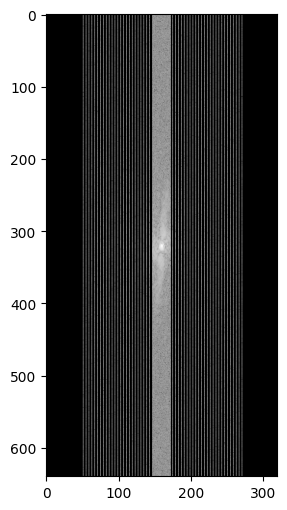

In [39]:
# Show GRAPPA MASK for R=4
slice_idx = 4
fig = plt.figure(figsize=(12,6))
plt.imshow(np.log(np.abs(fastmri.complex_abs(masked_kspace).numpy()[3,:,:,:]) + 1e-9)[slice_idx], cmap='gray')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/GRAPPA R=4.png')



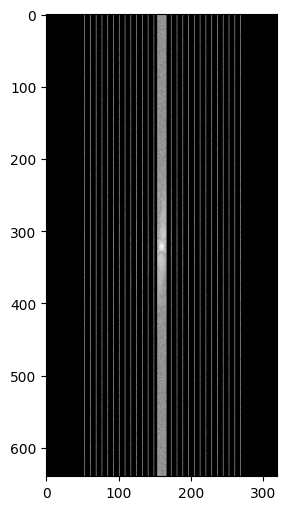

In [37]:
# Show GRAPPA MASK for R=8
mask_func = create_mask_for_mask_type('equispaced', [0.04], [8]) 
masked_kspace, mask, _ = T.apply_mask(kspace_torch, mask_func)

slice_idx = 4
fig = plt.figure(figsize=(12,6))
plt.imshow(np.log(np.abs(fastmri.complex_abs(masked_kspace).numpy()[3,:,:,:]) + 1e-9)[slice_idx], cmap='gray')
plt.savefig('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/figures/GRAPPA R=8.png')

In [27]:
# Now, let's apply grappa

from pygrappa import grappa
import torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    """
    Convert numpy array to PyTorch tensor.

    For complex arrays, the real and imaginary parts are stacked along the last
    dimension.

    Args:
        data: Input numpy array.

    Returns:
        PyTorch version of data.
    """
    if np.iscomplexobj(data):
        data = np.stack((data.real, data.imag), axis=-1)

    return torch.from_numpy(data)

def tensor_to_complex_np(data: torch.Tensor) -> np.ndarray:
    """
    Converts a complex torch tensor to numpy array.

    Args:
        data: Input data to be converted to numpy.

    Returns:
        Complex numpy version of data.
    """
    return torch.view_as_complex(data).numpy()

def apply_grappa(masked_kspace, mask):
    """
    Applies GRAPPA algorithm
    References
    ----------
    [1] Griswold, Mark A., et al. "Generalized autocalibrating
       partially parallel acquisitions (GRAPPA)." Magnetic
       Resonance in Medicine: An Official Journal of the
       International Society for Magnetic Resonance in Medicine
       47.6 (2002): 1202-1210.
    Args:
        masked_kspace (torch.Tensor): Multi-coil masked input k-space of shape (num_coils, rows, cols, 2)
        mask (torch.Tensor): Applied mask of shape (1, 1, cols, 1)
    Returns:
        preprocessed_masked_kspace (torch.Tensor): Output of GRAPPA algorithm applied on masked_kspace
    """

    def get_low_frequency_lines(mask):
        l = r = mask.shape[-2] // 2
        while mask[..., r, :]:
            r += 1

        while mask[..., l, :]:
            l -= 1

        return l + 1, r

    l, r = get_low_frequency_lines(mask)
    num_low_freqs = r - l
    pad = (mask.shape[-2] - num_low_freqs + 1) // 2
    calib = masked_kspace[:, :, pad:pad + num_low_freqs].clone()
    preprocessed_masked_kspace = grappa(tensor_to_complex_np(masked_kspace), tensor_to_complex_np(calib), kernel_size=(5, 5), coil_axis=0)
    return to_tensor(preprocessed_masked_kspace)


# Needs to be applied slice-wise
grappa_data = torch.zeros([masked_kspace.shape[0],masked_kspace.shape[1],masked_kspace.shape[2],masked_kspace.shape[3],masked_kspace.shape[4]])
for slice in range(masked_kspace.shape[0]):
    grappa_data[slice,:,:,:,:] = apply_grappa(masked_kspace[slice,:,:,:,:], mask[0,:,:,:,:])


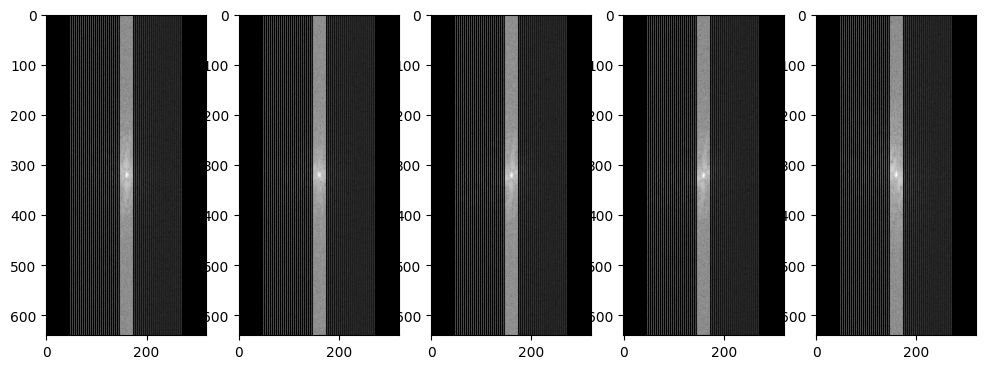

In [28]:
import fastmri

def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(12,6))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

show_coils(np.log(np.abs(fastmri.complex_abs(masked_kspace).numpy()[3,:,:,:]) + 1e-9), [0, 2, 5, 7, 10], cmap='gray')


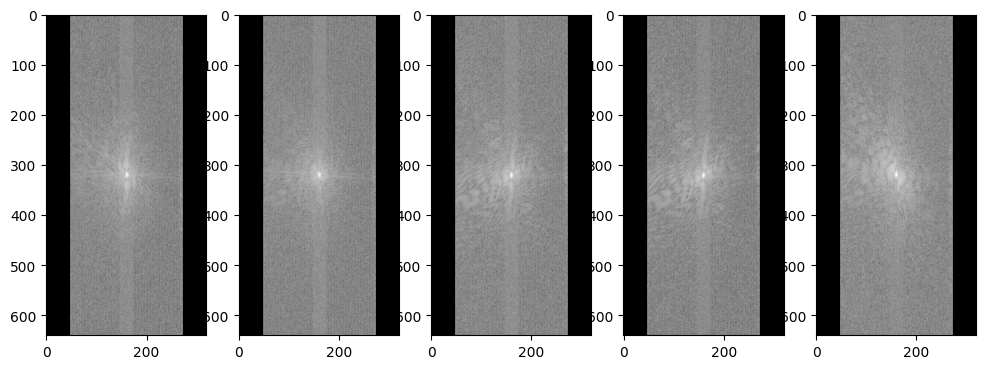

In [16]:
show_coils(np.log(np.abs(fastmri.complex_abs(grappa_data).numpy()[3,:,:,:]) + 1e-9), [0, 2, 5, 7, 10], cmap='gray')


In [17]:
grappa_data_np = tensor_to_complex_np(grappa_data)


In [18]:
def find_first_zero_after_first_non_zero(arr):
    """
    Find the first zero element that appears after the first non-zero element in a 1D numpy array.

    Parameters:
    arr (numpy.ndarray): The input 1D numpy array.

    Returns:
    tuple: A tuple containing the first zero element after the first non-zero element and its index.
    """
    # Find the first non-zero element and its index
    first_non_zero_index = None
    for i, elem in enumerate(arr):
        if elem!= 0:
            first_non_zero_index = i
            break

    # If no non-zero element is found, return None and -1
    if first_non_zero_index is None:
        return None, -1

    # Search for the first zero element after the first non-zero element
    for i in range(first_non_zero_index + 1, len(arr)):
        if arr[i] == 0:
            return 0, i  # Return 0 and its index since we're looking for the first zero

    # If no zero is found after the first non-zero element, return None and -1
    return None, -1


first_zero_after_first_non_zero, index = find_first_zero_after_first_non_zero(np.abs(grappa_data_np[3,5,320,:]))
print(f"First zero after first non-zero element: {first_zero_after_first_non_zero}, Index: {index}")


First zero after first non-zero element: 0, Index: 272


Here, we can visualize the results of our GRAPPA preprocessing in the image domain

In [19]:
slice_grappa = grappa_data[3,:,:,:,:]


In [20]:
import fastmri
slice_zf_image_T = fastmri.ifft2c(masked_kspace[3])
slice_zf_image_abs = fastmri.complex_abs(slice_zf_image_T)
slice_zf_image_rss = fastmri.rss(slice_zf_image_abs, dim=0)


In [21]:
def comp_img(img,crop_size):
    s = img.shape
    start_height = s[0]//2 - (crop_size[0]//2)
    start_width = s[1]//2 - (crop_size[1]//2)
    return img[start_height:(start_height+crop_size[0]),start_width:(start_width+crop_size[1])]

dim1 = GT.shape[1]
dim2 = GT.shape[2]
slice_zf_image_rss = comp_img(slice_zf_image_rss.numpy(),(dim1,dim2))


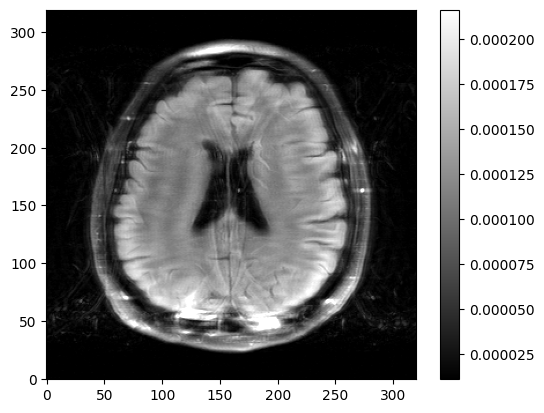

In [22]:
plt.imshow(np.abs(slice_zf_image_rss), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


In [23]:
slice_grappa_image_T = fastmri.ifft2c(slice_grappa)
slice_grappa_image_abs = fastmri.complex_abs(slice_grappa_image_T)
slice_grappa_image_rss = fastmri.rss(slice_grappa_image_abs, dim=0)
slice_grappa_image_rss = comp_img(slice_grappa_image_rss.numpy(),(dim1,dim2))


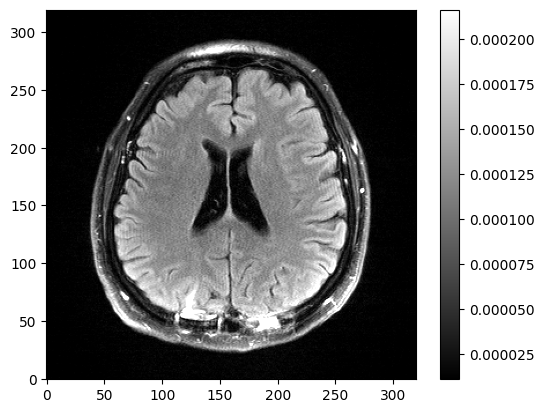

In [24]:
plt.imshow(np.abs(slice_grappa_image_rss), cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()


In [25]:
# Now let's see the ZF UNet reconstruction after passing the ZF scan to the UNet trained on ZF GRAPPA masks
hf = h5py.File(os.path.join('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNet/Epoch47/reconstructions_regularized_R3/', file_name),'r')
reconstruction = hf['reconstruction']
reconstruction = np.array(reconstruction)


OSError: Unable to open file (unable to open file: name = '/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Reconstructions/BaselineUNet/Epoch47/reconstructions_regularized_R3/file_brain_AXFLAIR_210_6001949.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

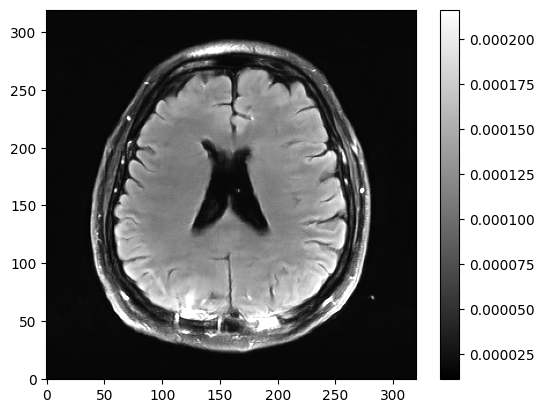

In [ ]:
plt.imshow(reconstruction[3], cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
